## Clustering Methods

In [406]:
# imports
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [407]:
# Load the csv file
df = pd.read_csv('data/data.csv')

feature_names = df.columns[:-1].to_list()
features = df.iloc[:, :-1].values
labels = df.iloc[:, -1].values
classes = np.unique(labels)

In [408]:
def plot_soft_clustering(memberships, title, legend=[]):
    N = memberships.shape[1]
    
    fig = plt.figure()

    if legend == []:
        legend = ['$\\omega_{' + str(i+1) + '}$' for i in range(N)]

    # get list of colors 
    cmap = plt.get_cmap('Set1')

    for point in range(len(features)):
        color = np.sum([np.array(cmap(i)) * memberships[point, i] for i in range(N)], axis=0)
        color = np.clip(color, 0, 1)

        plt.scatter(features[point, 0], features[point, 1], c=[color], edgecolors='k')

    
    plt.title(title)

    if len(legend) > 0:
        fig.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', label=legend[i], 
                                    markerfacecolor=cmap(i), markersize=10) for i in range(len(legend))],edgecolor='black', 
                loc='lower center', ncol=len(legend), fontsize='large', title='metacluster', bbox_to_anchor=(0.5, 0))
        
        plt.subplots_adjust(bottom=0.2)
                
    plt.show()

In [409]:
def plot_hard_clustering(clusters, title):
    # uses the soft clustering function to plot the hard clustering
    memberships = np.zeros((len(features), len(np.unique(clusters))))
    for i, c in enumerate(np.unique(clusters)):
        memberships[:, i] = clusters == c
    plot_soft_clustering(memberships, title)

## K-Means Clustering

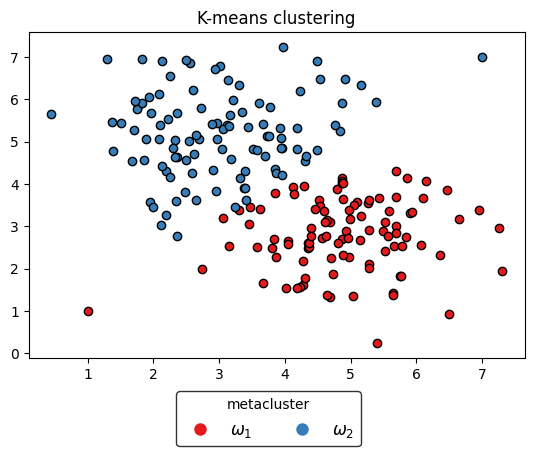

In [410]:
# K-means clustering
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, max_iter=20, random_state=42)
kmeans_labels = kmeans.fit_predict(features)
plot_hard_clustering(kmeans_labels, 'K-means clustering')

## Fuzzy C-Means Clustering

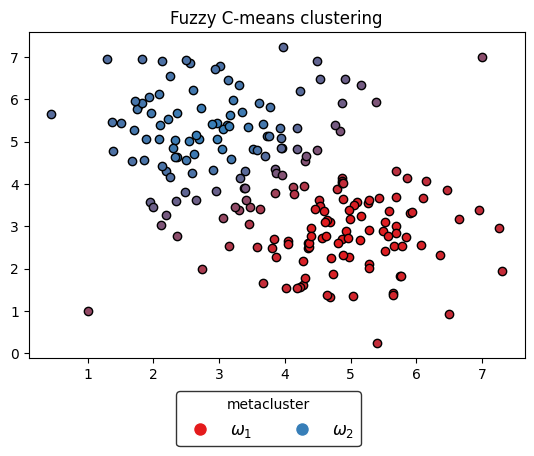

In [411]:
# Fuzzy C-means clustering
from fcmeans import FCM
fcm = FCM(n_clusters=2, random_state=42)
fcm.fit(features)
fcm_labels = fcm.predict(features)
fcm_centers = fcm.centers
fcm_membership = fcm.u

plot_soft_clustering(fcm_membership, 'Fuzzy C-means clustering')

## Evidential C-Means Clustering

- For the dataset $\mathbf{X}=\{x_1,\ldots,x_n\}$ we want to assign the entries into the clusters $\Omega=\left\{\omega_1, \ldots, \omega_c\right\}$.
- Let $F \subseteq 2^\Omega$ (be the focal set we are going to consider) and give it some order. We call each $F_j \in F$ a meta-cluster.
- (We will consider in the following, when not stated otherwise, $\emptyset \in F$, representing the outlier hypotesis, and $F \supset \{\{x\}: x \in X\}$, assering that ?.)
- We want to find a matrix $M \in[0,1]^{n \times 2^c}$ ($M_{i j}$ represents the mass of belief that $i$-th object is in the $j$-th meta-cluster)
- and a prototype matrix $V=\left[V_1, \ldots, V_c\right] \in \mathbb{R}^{c \times n}$ that represents the cluster centroids

We minimize
$$
\begin{aligned}
& \mathcal{J}_{E C M}(\mathbf{M}, \mathbf{V})=\sum_{i=1}^n \sum_{\substack{F_j \in F \\
F_j \neq \emptyset}}\left|F_j\right|^\alpha m_{i j}^\beta\left\|\mathbf{x}_i-\overline{\mathbf{v}}_j\right\|^2+\sum_{i=1}^n \delta^2 m_{i \emptyset}^\beta \\
& \text { subject to } \sum_{F_j \subseteq \Omega, F_j \neq \emptyset} m_{i j}+m_{i \emptyset}=1.
\end{aligned}
$$

With $\begin{aligned}& \bar{V}_j=\frac{1}{\left|F_j\right|} \sum_{W_k \in F_j} V_k\end{aligned}$ and $\alpha$, $\beta$ and $\delta$ parameters.

The parameters:
- The greater the $\alpha$ the more we penalize big metaclusters. The clustering will tend to concentrate belief masses on singletons.
- The greater the $\beta$ the more we dispenalize atributing a positive mass to a metacluster that is "far". The result will be fuzzier.
- The greater $\delta$ the more we penalize the outlier hypotesis.

Observations:
- If $\delta \rightarrow \infty$, the outlier hypotesis is excluded. This is equivalent to considering $\emptyset \notin F$.
- If $F =\{\{x\}: x \in X\}$, the ECM becomes the fuzzy C-means clustering.

In [412]:
# ECM clustering
from evclust.ecm import ecm
model = ecm(x=features, c=2, beta = 1.3,  alpha=1, delta=3, disp=False)

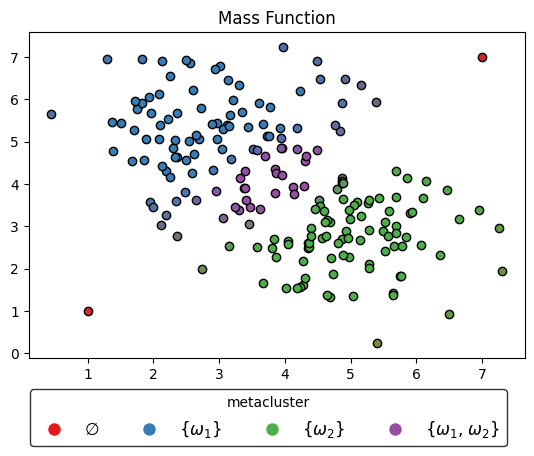

In [413]:
focal_sets = model['F']
focal_sets = ["{"+", ".join(["$\\omega_{" + str(i+1) + "}$" for i in range(len(f)) if f[i] == 1])+"}" for f in focal_sets]
focal_sets[0] = "$\emptyset$"

mass = model['mass']
plot_soft_clustering(mass, 'Mass Function', legend=focal_sets)

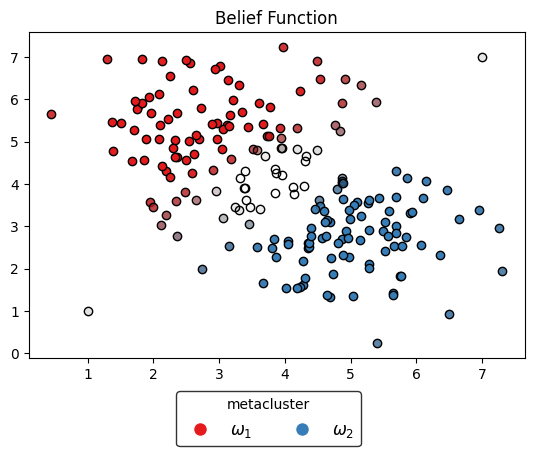

In [414]:
bel = model['bel']

plot_soft_clustering(bel, 'Belief Function')